In [1]:
import torch
from utils.checkpoints import load_checkpoint
from yolov1.model import YOLOv1
import torch.optim as optim
from argparse import Namespace
%load_ext autoreload
%autoreload 2 
# %aimport dataset


In [2]:
# <------------- Hyperparameters/Config ------------->
config = Namespace(
    DEVICE = torch.device("mps"), # apple silicon M series
    NUM_WORKERS = 2,
    PIN_MEMORY = True,
    
    EPOCHS = 50,
    LEARNING_RATE = 2e-5,
    BATCH_SIZE = 16, #64,
    WEIGHT_DECAY = 0, #TODO plasy with wight decay

    # load a model with weights that u have been trained to train it more
    LOAD_MODEL = True,
    LOAD_MODEL_FILE = "./checkpoints/Yolov1_facemask_objectDetection_epoch50_2025-04-10-05h_01m.pt",
    
    DATASET_DIR = "./data", # root path to the dataset dir
    IMAGE_SIZE = 448,

    C = 3, # how many classes in the dataset
    B = 2, # how many bounding boxes does the model perdict per cell
    S = 7, # split_size, how to split the image, 7x7=49 grid cells,
    IOU_THRESHOLD = 0.5, # the iou threshold when comparing bounding boxes for NMS
    MIN_THRESHOLD = 0.4, # the minimal confidence to keep a predicted bounding box
    PLOT_WHILE_TRAINING = True # bool to plot true and predicted bounding boxes on the images while training, this plot happens at random epochs
)

config.NUM_NODES_PER_CELL = config.C + 5 * config.B # The total number of nodes per cell, which would be the size ==> [with_mask, without_mask, mask_worn_incorrectly, pc_1, bbox1_x_y_w_h, pc_2, bbox2_x_y_w_h] = 13 nodes.
config.NUM_NODES_PER_IMG = config.S * config.S * (config.C + config.B * 5) # number of nodes that each image has. If S=7 C=3 B= 2 ==+> 7*7 * (3 + 2 * 5) = 637, also 13 * 49 = 637

In [3]:
import torchvision.transforms as T

# <------------- Transforms ------------->
class Compose(object):
    """Resize, normalize, and transform to tensor."""
    def __init__(self, transforms):
        self.T = transforms
    def __call__(self, img, bboxes):
        for t in self.T:
            img, bboxes = t(img), bboxes
        return img, bboxes

transforms = Compose([
T.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
T.ToTensor()
])

### Load Model From Checkpoint

In [4]:
model = YOLOv1(in_channels=3, S=config.S, B=config.B, C=config.C).to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
load_checkpoint(config.LOAD_MODEL_FILE, model, optimizer)


=> Loading Model from checkpoint.



### Test on an image the model was trained on

In [5]:
from torch.utils.data import DataLoader
from yolov1.dataset import Dataset 
from utils.plot import plot_bbox_on_img, visualize_grid_on_img
from utils.bboxes import resize_bbox_relative_to_img, convert_bboxes
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [6]:
d = Dataset(config.DATASET_DIR, S=7, B=2, C=3, transform=transforms)

CSV file exists!


In [7]:
img, label = d.__getitem__(1, plot_img=False)
img.shape, label.shape, img.device, label.device

(torch.Size([3, 448, 448]),
 torch.Size([7, 7, 13]),
 device(type='cpu'),
 device(type='cpu'))

In [8]:
img = img.to(config.DEVICE)
label = label.to(config.DEVICE)

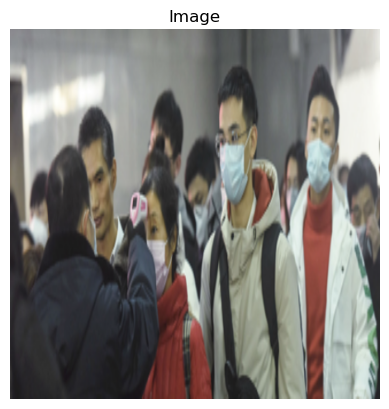

In [9]:
plt.imshow(F.to_pil_image(img))
plt.axis('off')
plt.title("Image")
plt.show()


In [10]:
input_img = img.unsqueeze(0) # add the batch_size dimension -> (3, 448, 448) -> (1, 3, 448, 448)
pred_bboxes = model(img.unsqueeze(0))
input_img.shape, pred_bboxes.shape

(torch.Size([1, 3, 448, 448]), torch.Size([1, 637]))

In [11]:
pred_bboxes

tensor([[ 6.6098e-01,  3.1765e-01,  9.1610e-02,  7.6257e-02,  8.5202e-01,
          6.3587e-01,  5.4275e-01,  6.5571e-01,  9.1694e-02,  6.1159e-01,
          5.5062e-01,  3.8997e-01,  7.1856e-01,  6.4544e-01,  6.9734e-01,
          5.0169e-02,  4.1229e-02,  9.1067e-01,  9.2489e-01,  1.1746e-01,
          4.9432e-01,  4.2807e-02,  4.6192e-01,  8.3055e-01,  6.0561e-01,
          1.1217e+00,  1.0147e+00,  3.2453e-01, -6.0664e-02, -2.9049e-02,
          5.4839e-01,  9.6969e-01,  8.3737e-01,  7.5601e-01, -1.3059e-02,
          5.3662e-01,  8.0618e-01,  1.0508e+00,  9.2770e-01,  1.2404e+00,
          1.8296e-01, -5.0524e-02, -1.2422e-01,  5.8703e-01,  6.9298e-01,
          3.2084e-01,  9.3732e-01,  1.4636e-02,  3.1421e-01,  9.8411e-01,
          5.4463e-01,  4.8009e-01,  7.7544e-01,  4.0074e-01, -2.1287e-03,
          5.3145e-02,  7.1834e-01,  1.1005e+00,  5.4962e-01,  8.4596e-01,
          9.2395e-02,  6.2413e-01,  1.0169e+00,  3.2579e-01,  8.3107e-01,
          7.1625e-01,  4.8767e-01,  1.

In [12]:
label

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000]

In [13]:
label.reshape(1, 637)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [ ]:
def plot_bboxes(img, true_bboxes, pred_bboxes, config):
    """
    Plot the bounding boxes from the predicted and the true bboxes on the image.
    
    Parameters
    ----------
    img : tensor
        The image tensor, shape of (3, 448, 448).
    true_bboxes : tensor
        The true bounding boxes, shape of (7, 7, 13).
    pred_bboxes : tensor
        The models predicted bounding boxes, shape of (1, 637).
    config : argparse.Namespace
        The configurations.
    """
    # convert true_bboxes from shape (7, 7, 13) into (1, 637)
    true_bboxes = true_bboxes.reshape(1, 637)
    
    # convert the pred and true bboxes from the ratio relative to its cell to being relative to the entire image, and remove the low confidence bounding boxes.
    pred_bboxes = convert_bboxes(pred_bboxes, config) # list [ [class_id, confidence_score, x1, y1, x2, y2] * for each cell in image, etc...   ]
    true_bboxes = convert_bboxes(true_bboxes, config) # list
    return true_bboxes

In [ ]:
plot_bboxes(img, label, pred_bboxes, config)

In [48]:
S = config.S
t_b = label.reshape(1, 637).to("cpu") # move tensor to cpu
t_b.shape[0]

1

In [49]:
batch_size = t_b.shape[0]
t_b = t_b.reshape(batch_size, S, S, config.NUM_NODES_PER_CELL) #reshape from (64, 637) -> (64, 7, 7, 13)
t_b.shape

torch.Size([1, 7, 7, 13])

In [50]:
bboxes1 = t_b[..., 4:config.NUM_NODES_PER_CELL-5] # grab the first bounding boxes coordinates( X, Y, W, H) for every cell. 
bboxes2 = t_b[..., 9:config.NUM_NODES_PER_CELL]
bboxes1, bboxes2

(tensor([[[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.2437, 0.4904, 0.6475, 1.5705],
           [0.9062, 0.3109, 0.5775, 1.5705],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          [[0.5687, 0.7244, 0.4025, 0.8974],
 

In [51]:
scores = torch.cat(
    (
        t_b[..., 3].unsqueeze(0),
        t_b[..., 8].unsqueeze(0)
    ), dim=0
)
scores

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 0.],
          [1., 1., 0., 1., 0., 1., 1.],
          [0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])

In [52]:
# create a tensor to store best bbox scores, ex             If the first box has a higher confidence per a cell, best_box will contain 0 at that cell vice versa for bbox2 would be a 1.
best_box = scores.argmax(0).unsqueeze(-1)
best_box

tensor([[[[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]],

         [[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]]]])

In [53]:
# now using that best_box tensor add to the bboxes1and2 to remove the the lower scored pc_1 probability score bounding boxes.
best_bboxes = bboxes1 * ( 1 - best_box) + best_box * bboxes2
best_bboxes

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.2437, 0.4904, 0.6475, 1.5705],
          [0.9062, 0.3109, 0.5775, 1.5705],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.5687, 0.7244, 0.4025, 0.8974],
          [0.4788, 0.7692,

In [54]:
# make a col like tensor to compute with the col cells and then switch it later to compute with the row cells
cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
cell_indices

tensor([[[[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]],

         [[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]],

         [[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]],

         [[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]],

         [[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]],

         [[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]],

         [[0],
          [1],
          [2],
          [3],
          [4],
          [5],
          [6]]]])

In [55]:

# Grab the x coordinate from the best bounding boxes. The 1 represents the entire image, divide by S how many cols or rows, to get thew size of a cell.
x = 1 / S * (best_bboxes[..., :1] + cell_indices)
# Grab the y coordinate from the best bounding boxes, also reorder (.permute()) the cell_indices tensor so we can multiply by the column
y = 1 / S * (best_bboxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
# grab teh W, H coordinates of the best bounding boxes
w_h = 1/S * best_bboxes[..., 2:4]
x, y, w_h

(tensor([[[[0.0000],
           [0.1429],
           [0.2857],
           [0.4286],
           [0.5714],
           [0.7143],
           [0.8571]],
 
          [[0.0000],
           [0.1429],
           [0.2857],
           [0.4286],
           [0.5714],
           [0.7143],
           [0.8571]],
 
          [[0.0000],
           [0.1429],
           [0.2857],
           [0.4286],
           [0.6063],
           [0.8438],
           [0.8571]],
 
          [[0.0812],
           [0.2113],
           [0.2857],
           [0.5150],
           [0.5714],
           [0.7675],
           [0.9588]],
 
          [[0.0000],
           [0.1429],
           [0.3963],
           [0.4286],
           [0.5714],
           [0.7143],
           [0.8571]],
 
          [[0.0000],
           [0.1429],
           [0.2857],
           [0.4286],
           [0.5714],
           [0.7143],
           [0.8571]],
 
          [[0.0000],
           [0.1429],
           [0.2857],
           [0.4286],
           [0.57

In [24]:
# concat the bounding boxes that have been converted to the ratio of entire image
converted_best_bboxes = torch.cat((x, y, w_h), dim=-1)

# grab the 3 class predictions
predicted_classes = t_b[..., :3].argmax(-1).unsqueeze(-1)

# Grab the max/most confident from the two predicted bounding boxers for every cell
best_confidence = torch.max(t_b[..., 3], t_b[..., 8]).unsqueeze(-1)
# print(predicted_classes.shape, best_confidence.shape, converted_best_bboxes.shape)

converted = torch.cat(
    # concat ex: predicted_classes = (batch_size, 7, 7, 1)  +  best_confidence = (batch_size, 7, 7, 1) +  converted_best_bboxes = (batch_size, 7, 7, 4)   ==> (batch_size, 7, 7, 6)
    
    (predicted_classes, best_confidence, converted_best_bboxes),
    dim=-1
)    
converted

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1429, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2857, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4286, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5714, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.7143, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.8571, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1429, 0.1429, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2857, 0.1429, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4286, 0.1429, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5714, 0.1429, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.7143, 0.1429, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.8571, 0.1429, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.2857, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1429, 0.2857, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2857, 0